<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Методы машинного обучения</center></h1>
<h2><center>Выявление сообществ на сети, структурная схожесть</center></h2>

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

In [3]:
import networkx as nx

## Выявление сообществ с помощью иерархической кластеризации
* Загрузим граф из `nested_partition.gml`. Это граф, построенный с помощью [генератора](https://sites.google.com/site/santofortunato/inthepress2) Benchmark сетей для тестов алгоритмов выявления сообществ.
* Визуализируем матрицу смежности графа с помощью метода `plt.spy(A)` (и саму сеть, если получится)
* Рассчитаем реализованные в `nexworkx` меры схожести вершин

По большому счету, полученные схожести можно подавать на вход любому алгоритму кластеризации, который изначально может работать со мерами близости (например аггломеративная кластеризация)

In [4]:
g = nx.read_gml('./data/nested_partition.gml', label='id')

In [5]:
g.number_of_nodes()

128

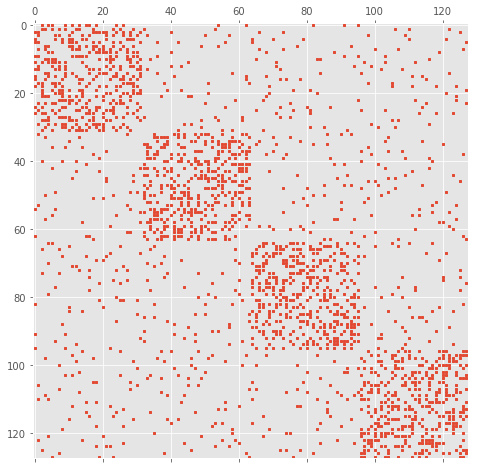

In [6]:
A = nx.adj_matrix(g)
plt.spy(A, markersize=2)

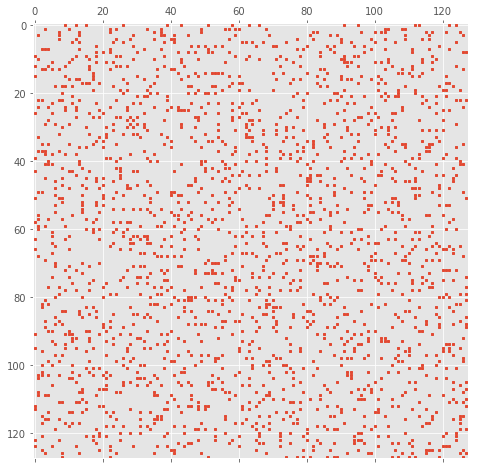

In [7]:
# Что бы мы увидили в реальной жизни
idx = np.random.permutation(range(128))
i = np.ix_(idx, idx)
plt.spy(A[i], markersize=2)

In [8]:
# Все положительные похожести по Жаккару
jac = nx.jaccard_coefficient(g)
jac = np.array(list(jac))

In [9]:
jac
# id1, id2, jaccard_coef

array([[0.00000000e+00, 1.00000000e+00, 1.42857143e-01],
       [0.00000000e+00, 3.00000000e+00, 6.66666667e-02],
       [0.00000000e+00, 6.00000000e+00, 2.80000000e-01],
       ...,
       [1.23000000e+02, 1.27000000e+02, 6.66666667e-02],
       [1.24000000e+02, 1.26000000e+02, 6.66666667e-02],
       [1.24000000e+02, 1.27000000e+02, 1.42857143e-01]])

In [10]:
# Немного магии, чтобы получить из этого матрицу попарных СХОЖЕСТЕЙ по жаккару
from scipy.sparse import coo_matrix

# Переводим все в формат разреженной матрицы
D = coo_matrix((jac[:,2], (jac[:,0], jac[:,1])), shape=(128,128))

# Делаем ее симметричной
D = D+D.T

# Делаем ее плотной и вычитаем из 1, чтобы получить РАССТОЯНИЕ
D = 1 - D.toarray() - np.eye(128)

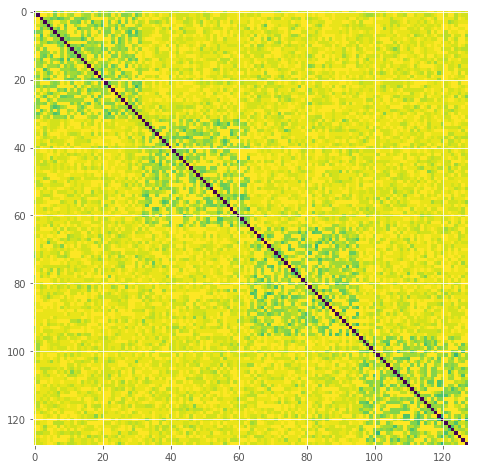

In [11]:
plt.imshow(D)

In [12]:
# Попробуем посчитать на этой матрице рассстойний иерархическую кластеризацию
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import squareform, pdist

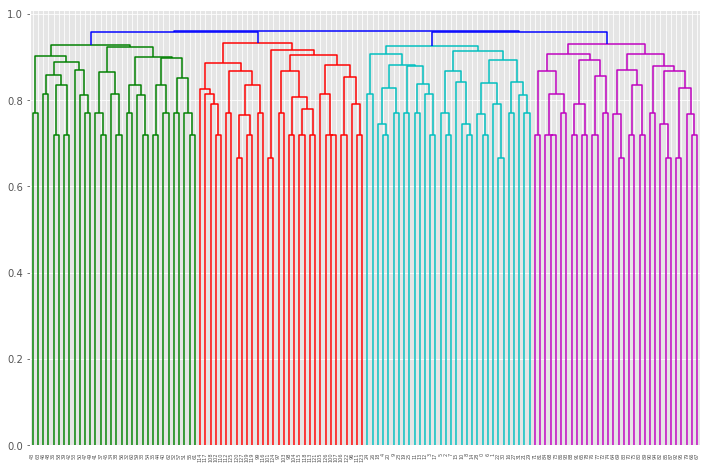

In [21]:
d = squareform(D) # преобразование матрицы в вектор расстояний
Z = linkage(d, method='average')
dend = dendrogram(Z, color_threshold=0.95)
labels = fcluster(Z, 6, criterion='maxclust')

In [22]:
true_labeling = list(nx.get_node_attributes(g, 'label').values())

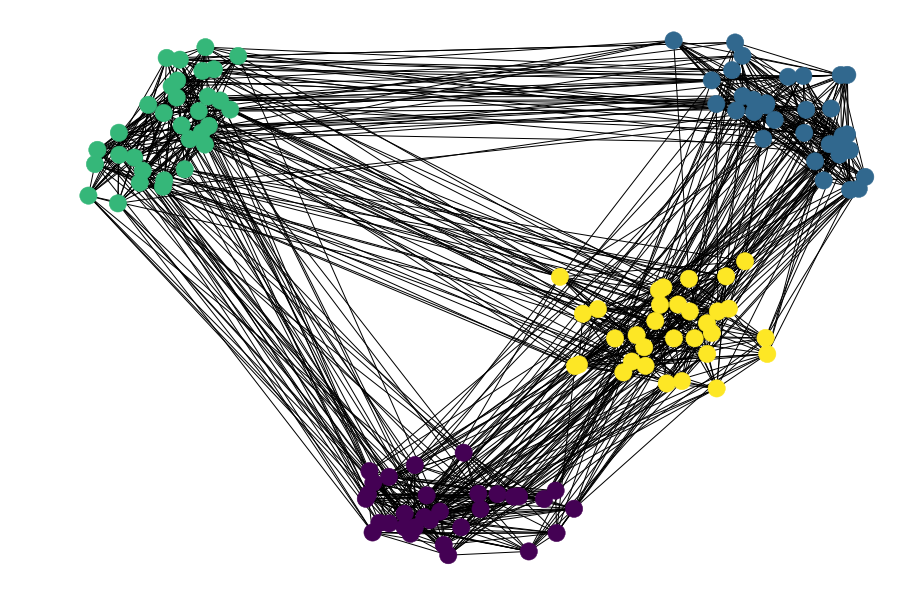

In [23]:
layout = nx.layout.spectral_layout(g)
nx.draw(g, pos=layout, node_color=true_labeling,)

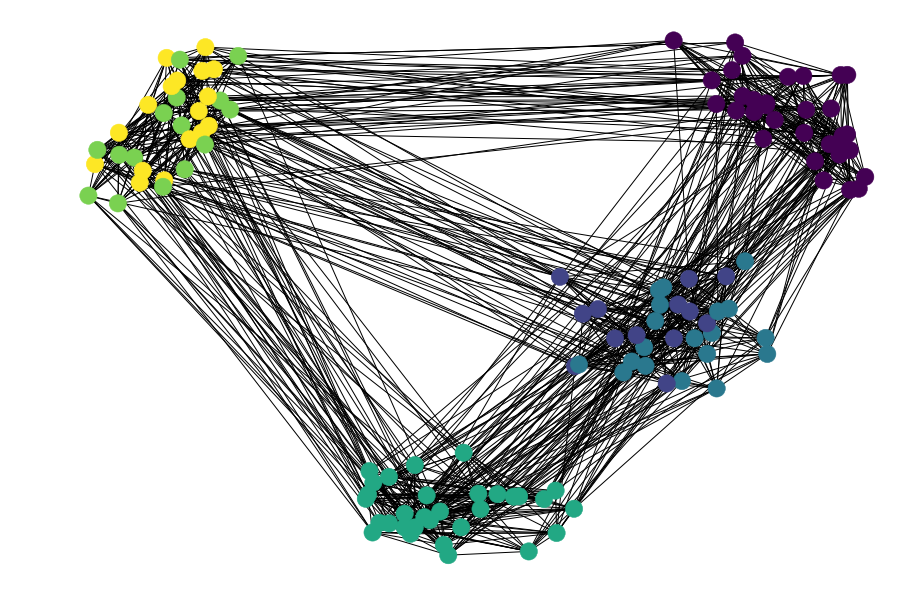

In [24]:
nx.draw(g, pos=layout, node_color=labels)

## Label propagation

Методы для выявления сообществ, которые реализованы в networkX можно найти [тут](https://networkx.github.io/documentation/stable/reference/algorithms/community.html#module-networkx.algorithms.community.community_utils)

In [25]:
nx.__version__

'2.1'

In [62]:
lp_partition = nx.community.asyn_lpa_communities(g) # должен быть seed

In [63]:
lp_partition = list(lp_partition) # разбиение на сообщества 

In [64]:
len(lp_partition)

3

In [46]:
# Функция, которая из разбиения получает разметку для каждого объекта
def get_labeling_from_partition(partition):
    
    all_nodes = set()
    for cluster in partition:
        all_nodes |= cluster
    num_nodes = len(all_nodes)
    labeling = np.ones((num_nodes,), dtype=int)

    for label, ids in enumerate(partition):
        ids = list(ids)
        labeling[ids] = label
        
    return labeling

In [65]:
lp_labeling = get_labeling_from_partition(lp_partition)

In [66]:
lp_labeling

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

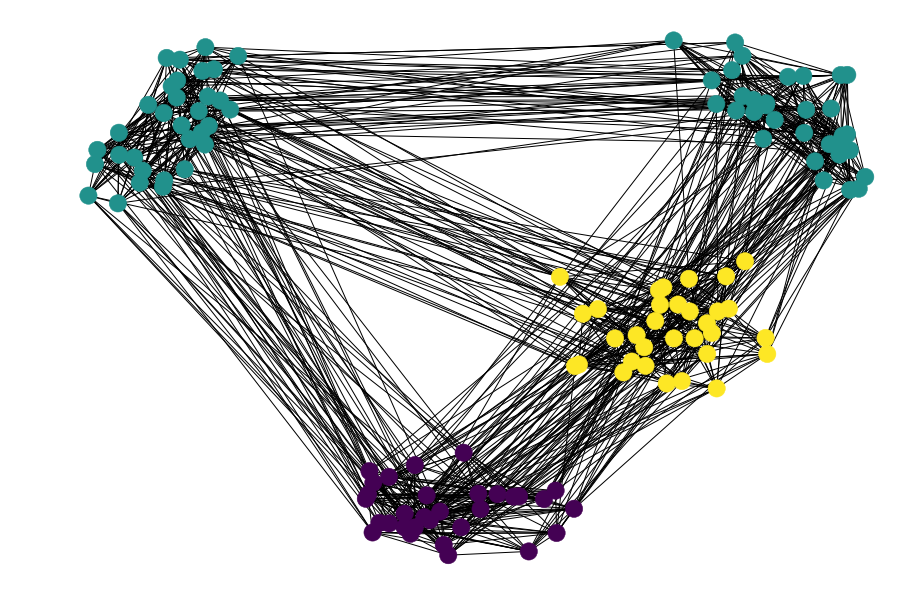

In [67]:
nx.draw(g, pos=layout, node_color=lp_labeling)

## Edge betweenness

In [74]:
eb_partitions = nx.community.girvan_newman(g)

In [75]:
# k = 4 # Вернем разбиение на k сообщества
# for partition in eb_partitions:
#     if len(partition) <= k:
#         print('Partition')
#         print(', '.join(map(lambda c: str(len(c)), 
#                            partition)))
        

In [76]:
k = 4 # Вернем разбиение на k сообщества
for partition in eb_partitions:
    if len(partition) == k:
        break

In [77]:
eb_partition = list(partition) # разбиение на сообщества 

In [78]:
eb_labeling = get_labeling_from_partition(eb_partition)

In [79]:
eb_labeling

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

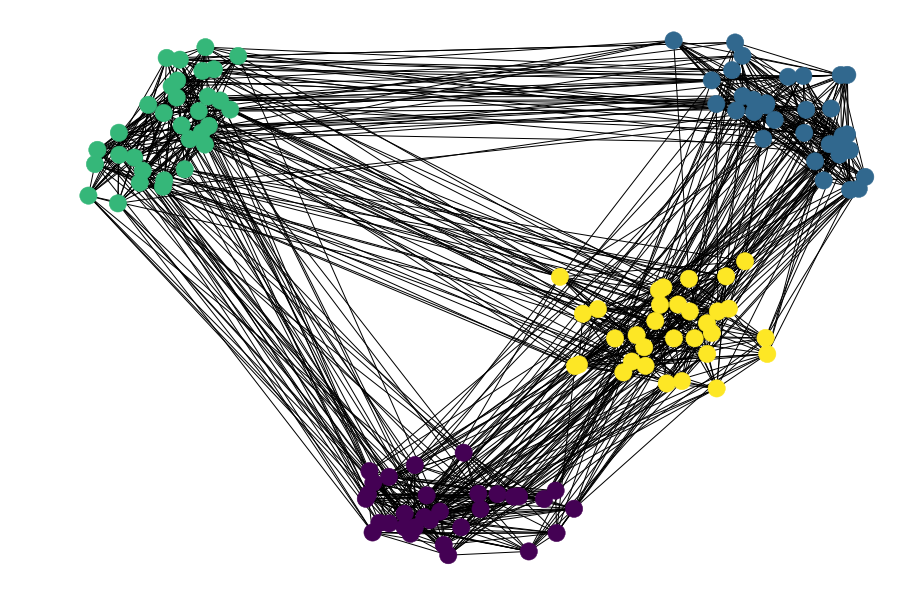

In [80]:
nx.draw(g, pos=layout, node_color=eb_labeling)

### Modularity

In [81]:
# Просто функция, которая считает модулярность
from itertools import product
def modularity(G, communities, weight='weight'):
    multigraph = G.is_multigraph()
    directed = G.is_directed()
    m = G.size(weight=weight)
    if directed:
        out_degree = dict(G.out_degree(weight=weight))
        in_degree = dict(G.in_degree(weight=weight))
        norm = 1 / m
    else:
        out_degree = dict(G.degree(weight=weight))
        in_degree = out_degree
        norm = 1 / (2 * m)

    def val(u, v):
        try:
            if multigraph:
                w = sum(d.get(weight, 1) for k, d in G[u][v].items())
            else:
                w = G[u][v].get(weight, 1)
        except KeyError:
            w = 0
        # Double count self-loops if the graph is undirected.
        if u == v and not directed:
            w *= 2
        return w - in_degree[u] * out_degree[v] * norm

    Q = sum(val(u, v) for c in communities for u, v in product(c, repeat=2))
    return Q * norm

In [82]:
eb_partitions = nx.community.girvan_newman(g)

In [83]:
# Посчитаем модулярность для разбиений на 1,2,..10 сообществ
for partition in eb_partitions:
    num_com = len(partition)
    if num_com < 10:
        mod = modularity(g, partition)
        print('For {} communities modularity = {}'.format(num_com, mod))
    else:
        break

For 2 communities modularity = 0.228515625
For 3 communities modularity = 0.380859375
For 4 communities modularity = 0.453125
For 5 communities modularity = 0.4471435546875
For 6 communities modularity = 0.4400634765625
For 7 communities modularity = 0.433837890625
For 8 communities modularity = 0.428466796875
For 9 communities modularity = 0.4249267578125


# Пример расчета Асортативности

В файле `Princeton.gml` содержится граф дружбы студентов соответствующих, собранных в 2005 году из Facebook. Каждая вершина обладает следующими аттрибутами:
* Факультет
* Пол
* Основное направление подготовки
* Дополнительный направление подготовки (если есть)
* Общежитие проживания, домашнее проживание
* Год поступления
* Школа

Пропуски помечены значением `0`.

#### Задание
Посчитайте ассортативность для каждого из аттрибутов и ассортативность по степени узлов.

Сравните результаты между сетями и проинтерпретируйте их.

In [84]:
!head ./data/Princeton.gml

Version 1
graph
[
  directed 0
  node
  [
    id 0
    status 2
    major 298
    gender 2


In [85]:
g = nx.read_gml('./data/Princeton.gml', label='id')

In [86]:
attributes = g.node[0]

In [87]:
attributes = g.node[0].keys()

In [88]:
attributes

dict_keys(['status', 'major', 'gender', 'major2', 'school', 'year', 'dorm'])

In [89]:
for attr in attributes:
    print('{} assortativity = {}'.format(attr, 
                                         nx.assortativity.attribute_assortativity_coefficient(g, attr)))

status assortativity = 0.4822395993165163
major assortativity = 0.054390118871393854
gender assortativity = 0.05061073999529183
major2 assortativity = 0.015189252032913315
school assortativity = 0.018783655244969704
year assortativity = 0.44674462058408704
dorm assortativity = 0.09467841955418972


In [91]:
# nx.assortativity.numeric_assortativity_coefficient(g, attribure_name) 
# Для числовых признаков

In [92]:
# Матрица перемешивания e_ij
E = nx.assortativity.attribute_mixing_matrix(g, 'year')

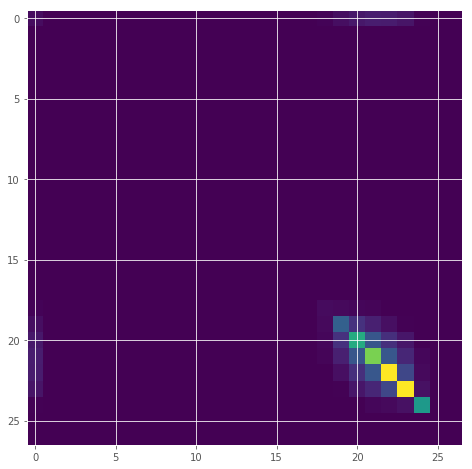

In [93]:
plt.imshow(E)

In [94]:
nx.assortativity.degree_assortativity_coefficient(g)

0.09109212356796509